# Likelihood

Showing/testing basic functionalities regarding likelihood

In [1]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import json 
import numpy as np
import matplotlib.pyplot as plt

import copy
import inspect 
# matlotlib settings
mpl_params = {"axes.grid": True,
        "text.usetex" : False, # TODO enable latex, but this breaks if filters have underscore
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}
plt.rcParams.update(mpl_params)
import nmma as nmma
from nmma.em.io import loadEvent
from nmma.em.model import SVDLightCurveModel
import nmma.em.model_parameters as model_parameters
MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
MODEL_NAME = "Bu2022Ye"
model_function = MODEL_FUNCTIONS[MODEL_NAME]
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
import jax.numpy as jnp

from kim.likelihood import OpticalLightCurve

ModuleNotFoundError: No module named 'nmma'

## Set up data and model

Load the data and specify which parameters are fixed now

In [68]:
data_file = "../data/AT2017gfo_corrected_no_inf.dat"
trigger_time = 57982.5285236896
tmin, tmax = 0.05, 14
data = loadEvent(data_file)
filters = list(data.keys())
print("Filters: ", filters)
sample_times = jnp.linspace(tmin, tmax, 1_000)

Filters:  ['ps1__g', 'ps1__r', 'ps1__i', 'ps1__z', 'ps1__y', '2massj', '2massh', '2massks', 'sdssu']


In [69]:
fixed_params = {'luminosity_distance': 44.0, 
                 'timeshift': 0.0}

Example of good parameters for this dataset

In [70]:
ml_params = {'log10_mej_dyn': -2.8864446440804197, 
             'vej_dyn': 0.13052120250720384, 
             'Yedyn': 0.23967937434215597, 
             'log10_mej_wind': -1.1819706730450323, 
             'vej_wind': 0.030019975460791992, 
             'inclination_EM': 0.9357809063909895,
}

## Lightcurve model

In [71]:
svd_path_flax = "/home/urash/twouters/flax_models"
lc_model_flax = SVDLightCurveModel(
        MODEL_NAME,
        sample_times,
        svd_path=svd_path_flax,
        parameter_conversion=None,
        mag_ncoeff=10,
        lbol_ncoeff=None,
        interpolation_type="flax",
        model_parameters=None,
        filters=filters,
        local_only=True
)

WATCH OUT: NMMA source code for flax is broken here so setting self.svd_path by hand
/home/urash/twouters/flax_models
/home/urash/twouters/flax_models/Bu2022Ye.pkl


## Likelihood

In [72]:
likelihood = OpticalLightCurve(lc_model_flax,
                               filters,
                               data,
                               trigger_time,
                               fixed_params=fixed_params,
)

In [73]:
ml_lightcurve = likelihood.calc_lc(ml_params)

Plot the data and the lightcurve

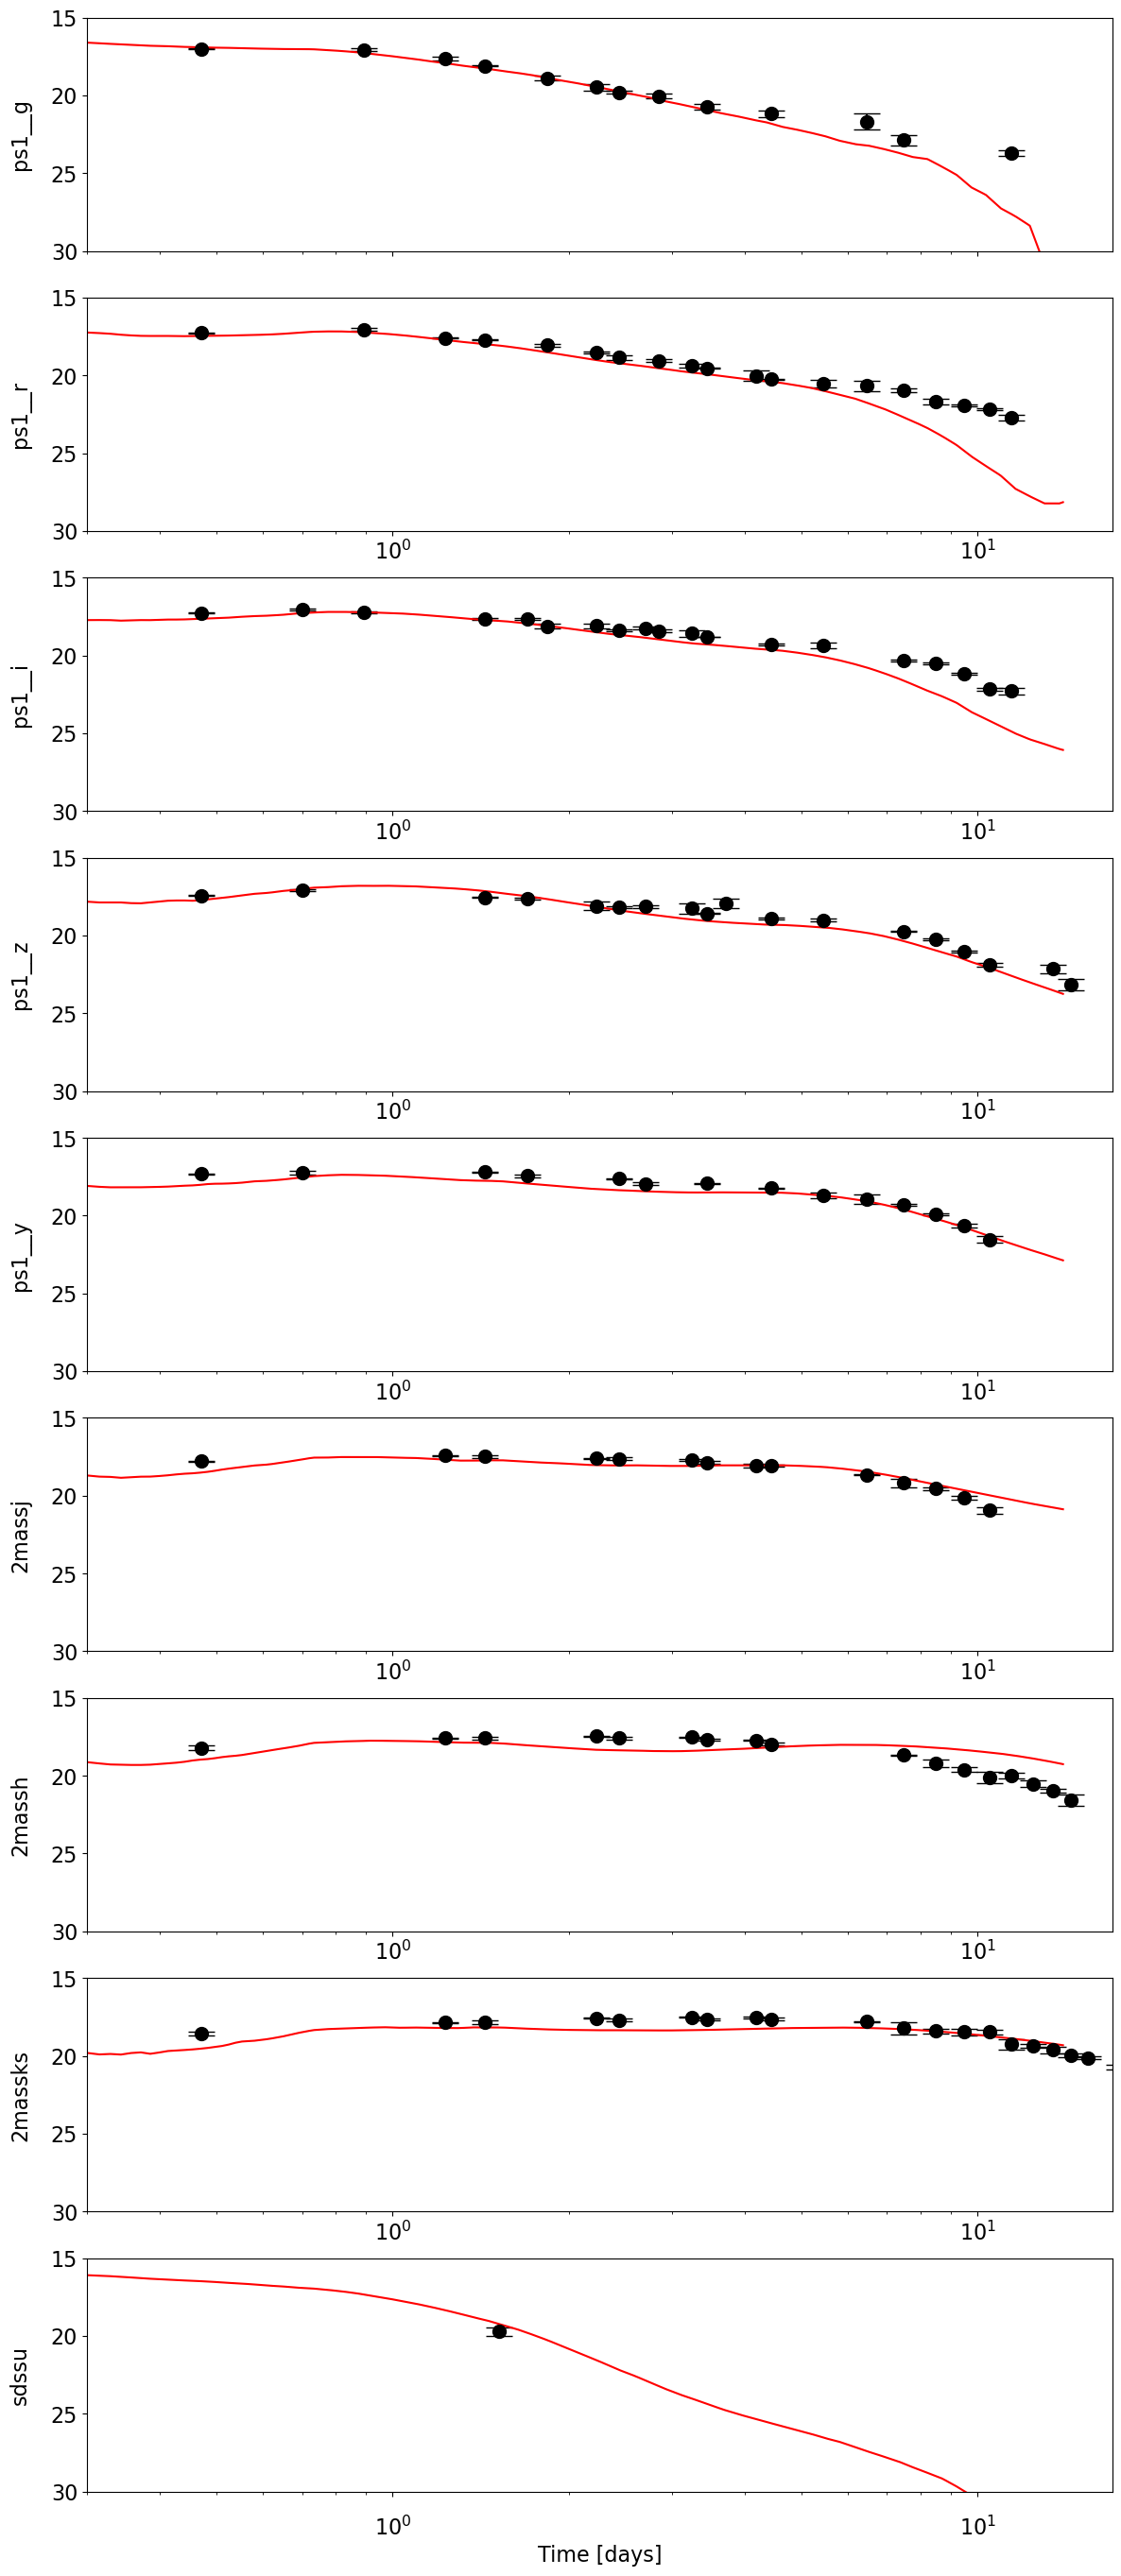

In [74]:
### Plot hyperparameters
set_ylim = True
set_yticks = True
show_data = True

error_budget = '1.0'
error_budget = [float(x) for x in error_budget.split(",")]
error_budget = dict(zip(filters, error_budget * len(filters)))
xlim = f"{tmin},{tmax}"
ylim = "32, 15"
x_left = 3e-1
x_right = tmax + 3

# colors = cm.Spectral(np.linspace(0, 1, len(filters)))[::-1]

plt.figure(figsize=(14, 34))

cnt = 0
for filt in filters:
    cnt = cnt + 1
    if cnt == 1:
        ax1 = plt.subplot(len(filters), 1, cnt)
    elif cnt == 2 or cnt == 3:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)
    else:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)

    samples = data[filt]
    t, y, sigma_y = copy.deepcopy(samples[:, 0]), copy.deepcopy(samples[:, 1]), copy.deepcopy(samples[:, 2])
    t -= trigger_time   
    idx = np.where(~np.isnan(y))[0]
    t, y, sigma_y = t[idx], y[idx], sigma_y[idx]

    # 1) plot data points
    idx = np.where(np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="o", color='k', markersize=10, capsize=10)
    # plot upper bounds
    idx = np.where(~np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="v", color='k', markersize=10, capsize=10)

    # 2) plot tensorflow model
    my_mag = ml_lightcurve[filt]
    plt.plot(likelihood.sample_times, my_mag, color="red")
    
    #plt.ylim([float(x) for x in ylim.split(",")])
    plt.xlim([float(x) for x in xlim.split(",")])
    plt.xscale('log')
    plt.grid()
    
    filt_label = filt
    
    if cnt == 1:
        
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax1.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])
    else:
        # filt_label = filt.replace("__", "-")
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax2.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])

    if cnt == 1:
        if set_yticks:
            ax1.set_yticks([30, 25, 20, 15])
        else:
            ax1.invert_yaxis()
        ax1.set_xlim(left=x_left, right=x_right)
        plt.setp(ax1.get_xticklabels(), visible=False)
        # legend = plt.legend(loc = "center", bbox_to_anchor=(0.5, 1.2), shadow=False,
        #                     fancybox=True, ncol=4)
        # legend.get_frame().set_alpha(None)
        
    else:
        if set_yticks:
            ax2.set_yticks([30, 25, 20, 15])
        else:
            ax2.invert_yaxis()
        ax2.set_xlim(left=x_left, right=x_right)

ax1.set_zorder(1)
plt.xlabel("Time [days]")
ax2.tick_params(axis='x', which='major', pad=15)
#plt.legend(bbox_to_anchor=(0., 12.9, 1.025, .0), ncol=2, fontsize=40, frameon=True)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0)


if show_data:
    plt.show()
else:
    plt.close()

Evaluate the likelihood:

In [75]:
likelihood.evaluate(ml_params, {})

DEBUG: filter: ps1__g
DEBUG: filter: ps1__r
DEBUG: filter: ps1__i
DEBUG: filter: ps1__z
DEBUG: filter: ps1__y
DEBUG: filter: 2massj
DEBUG: filter: 2massh
DEBUG: filter: 2massks
DEBUG: filter: sdssu


Array(-182.71288384, dtype=float64)

## Check integration with flowMC

In [76]:
from jimgw.prior import Uniform, Composite

In [77]:
log10_mej_dyn_prior = Uniform(-3.0, -1.7, naming=["log10_mej_dyn"])
vej_dyn_prior = Uniform(0.12, 0.25, naming=["vej_dyn"])
Yedyn_prior = Uniform(0.15, 0.3, naming=["Yedyn"])
log10_mej_wind_prior = Uniform(-2.0, -0.89, naming=["log10_mej_wind"])
vej_wind_prior = Uniform(0.03, 0.15, naming=["vej_wind"])
inclination_EM_prior = Uniform(0., np.pi/2., naming=["inclination_EM"])

prior_list = [log10_mej_dyn_prior, 
              vej_dyn_prior, 
              Yedyn_prior, 
              log10_mej_wind_prior, 
              vej_wind_prior, 
              inclination_EM_prior]

n_dim = len(prior_list)
prior_range = [[prior.xmin, prior.xmax] for prior in prior_list]
composite_prior = Composite(prior_list)

In [78]:
print(len(ml_params))

9


In [79]:
likelihood.evaluate(composite_prior.transform(ml_params), {})

DEBUG: filter: ps1__g
DEBUG: filter: ps1__r
DEBUG: filter: ps1__i
DEBUG: filter: ps1__z
DEBUG: filter: ps1__y
DEBUG: filter: 2massj
DEBUG: filter: 2massh
DEBUG: filter: 2massks
DEBUG: filter: sdssu


Array(-182.71288384, dtype=float64)